# Mechanism of action 

## Definition
In pharmacology, the term mechanism of action (MOA) refers to the specific biochemical interaction through which a drug substance produces its pharmacological effect. A mechanism of action usually includes mention of the specific molecular targets to which the drug binds, such as an enzyme or receptor. Receptor sites have specific affinities for drugs based on the chemical structure of the drug, as well as the specific action that occurs there.

Find here below an example of how beta-blockers work.

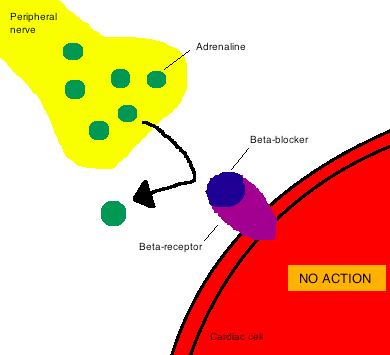

## How Mechanism of Action Is Determined
When scientists are researching antibiotic treatments in the lab, they can see how effective different medications are at fighting specific bacteria. They study the cells closely and watch how they interact. Their observations reveal how the drug attacks and kills the bacteria.

When they discuss the exact way that a drug works on its target, they refer to it as the medication's mechanism of action.

Drugs bind to receptors that are located on the surface of cells or within the cytoplasm (a jelly-like substance inside a cell). After the receptors bind to a cell, the drug will take on one of two roles: agonist or antagonist.

## Agonists vs. Antagonists
Drugs that are agonists activate the receptors they bind to. This bond will either increase or decrease the activity within the cell. Antagonist drugs do the opposite; they will block the receptors and prevent the natural agonists within the body from binding.

Most drugs bind to a specific type of receptor (which is known as receptor selectivity). The ability of a drug to bind to a certain receptor is determined by its unique chemical structure.

## Why mechanism of action is important

Elucidating the mechanism of action of novel drugs and medications is important for several reasons:

- In the case of anti-infective drug development, the information permits anticipation of problems relating to clinical safety. Drugs disrupting the cytoplasmic membrane or electron transport chain, for example, are more likely to cause toxicity problems than those targeting components of the cell wall (peptidoglycan or β-glucans) or 70S ribosome, structures which are absent in human cells.

- By knowing the interaction between a certain site of a drug and a receptor, other drugs can be formulated in a way that replicates this interaction, thus producing the same therapeutic effects. Indeed, this method is used to create new drugs.

- It can help identify which patients are most likely to respond to treatment. Because the breast cancer medication trastuzumab is known to target protein HER2, for example, tumors can be screened for the presence of this molecule to determine whether or not the patient will benefit from trastuzumab therapy.

- It can enable better dosing because the drug's effects on the target pathway can be monitored in the patient. Statin dosage, for example, is usually determined by measuring the patient's blood cholesterol levels.

- It allows drugs to be combined in such a way that the likelihood of drug resistance emerging is reduced. By knowing what cellular structure an anti-infective or anticancer drug acts upon, it is possible to administer a cocktail that inhibits multiple targets simultaneously, thereby reducing the risk that a single mutation in microbial or tumor DNA will lead to drug resistance and treatment failure.

- It may allow other indications for the drug to be identified. Discovery that sildenafil inhibits phosphodiesterase-5 (PDE-5) proteins, for example, enabled this drug to be repurposed for pulmonary arterial hypertension treatment, since PDE-5 is expressed in pulmonary hypertensive lungs

In [ ]:
!pip install iterative-stratification

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.metrics import log_loss

from sklearn.preprocessing import LabelEncoder, QuantileTransformer

sns.set_style('whitegrid')

In [ ]:
DATA_PATH = '../input/lish-moa/'

TRAIN_FEATURES = DATA_PATH + 'train_features.csv'
TEST_FEATURES = DATA_PATH + 'test_features.csv'
TRAIN_TARGETS_NON_SCORED = DATA_PATH + 'train_targets_nonscored.csv'
TRAIN_TARGETS_SCORED = DATA_PATH + 'train_targets_scored.csv'

In [ ]:
train_features_df = pd.read_csv(TRAIN_FEATURES)
train_targets_df = pd.read_csv(TRAIN_TARGETS_SCORED)

In [ ]:
test_features_df = pd.read_csv(TEST_FEATURES)

# 1  - Predictive features

In [ ]:
train_features_df.head()

In [ ]:
print(f'There are {len(train_features_df)} samples.')
print(f'There are {len(train_features_df["sig_id"].unique())} unique samples.')
print(f'There are {len(train_features_df.columns)-1} predictive features.')
print(f'There are {(train_features_df.dtypes == "float64").sum()} continuous features.')
print(f'There are {len(train_targets_df.columns)-1} classes.')
print(f'{train_features_df.isna().sum().sum()} missing value')

print(f'TEST: There are {len(test_features_df)} samples to predict.')

## 1.1. - Type, time and dose

Let's first plot the distribution of the 3 categorical features.

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
sns.set_palette(sns.color_palette("icefire"))

sns.countplot(train_features_df['cp_type'], ax=ax[0][0])
ax[0][0].set_title('Train - cp_type distribution', fontsize=14, fontweight='bold')

sns.countplot(train_features_df['cp_time'], ax=ax[0][1])
ax[0][1].set_title('Train - cp_time distribution', fontsize=14, fontweight='bold')

sns.countplot(train_features_df['cp_dose'], ax=ax[0][2])
ax[0][2].set_title('Train - cp_dose distribution', fontsize=14, fontweight='bold')

sns.countplot(test_features_df['cp_type'], ax=ax[1][0])
ax[1][0].set_title('Test - cp_type distribution', fontsize=14, fontweight='bold')

sns.countplot(test_features_df['cp_time'], ax=ax[1][1])
ax[1][1].set_title('Test - cp_time distribution', fontsize=14, fontweight='bold')

sns.countplot(test_features_df['cp_dose'], ax=ax[1][2])
ax[1][2].set_title('Test - cp_dose distribution', fontsize=14, fontweight='bold')

fig.suptitle('Distributions of type, time and dose', fontsize=20, fontweight='bold')

fig.tight_layout(rect=[0, 0.03, 1, 0.90]);

## 1.2. - Gene features

In [ ]:
gene_features = list([x for x in list(train_features_df.columns) if "g-" in x])

print(f'There are {len(gene_features)} gene features.')

With more than 700 features, it will be difficult to plot every distribution of features. Instead we want to gather meta-statistics of each feature, plot the distribution and check if there are a significant portion of the features who have a skewed distribution of a high kurtosis.

**As meta-statistics, we will be interested in**:
- Mean
- Standard deviation 
- Skew
- Kurtosis

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(25, 20))
rand_feats = np.random.choice(gene_features, 25, replace=False)

fig.suptitle('Kernel density estimator of some gene features', fontsize=20, fontweight="bold")

for x in range(25):
    i = x // 5
    j = x % 5
    
    sns.kdeplot(train_features_df[rand_feats[x]], shade=True, label="Train", ax=ax[i][j])
    sns.kdeplot(test_features_df[rand_feats[x]], shade=True, label="Test", ax=ax[i][j])
    ax[i][j].set_title(rand_feats[x])

The distributions look like Gaussian variables with a low variance for the most part, which is not unusual for that kind of biological data. At least we don't notice a lot of outliers. I'd like to have more details by having a look at the boxplot of the distributions. This might give us additional information about the outliers.

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(22, 16))

fig.suptitle('Boxplot of some gene features', fontsize=20, fontweight="bold")

train_features_df[rand_feats].plot(
    kind='box', 
    subplots=True, 
    ax=ax,
);

As inferred with the distribution plot, we are indeed faced with distributions with a lot of outliers. The whiskers around the box are set at 1.5IQR where IQR is the interquartile range. That is usually a standard used to measure outliers.

#### Meta-statistics

Since we can't plot all the distributions of the features, let's first try to see how the meta-statistics (mean, std, kurtosis...) are distributed.

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle('Distributions of meta-statistics', fontsize=20, fontweight="bold")

sns.kdeplot(train_features_df[gene_features].mean(), shade=True, label="Train", ax=ax[0])
sns.kdeplot(test_features_df[gene_features].mean(), shade=True, label="Test", ax=ax[0])
ax[0].set_title("Mean", fontsize=14, fontweight="bold")

sns.kdeplot(train_features_df[gene_features].std(), shade=True, label="Train", ax=ax[1])
sns.kdeplot(test_features_df[gene_features].std(), shade=True, label="Test", ax=ax[1])
ax[1].set_title("Standard deviation", fontsize=14, fontweight="bold")

sns.kdeplot(train_features_df[gene_features].skew(), shade=True, label="Train", ax=ax[2])
sns.kdeplot(test_features_df[gene_features].skew(), shade=True, label="Test", ax=ax[2])
ax[2].set_title("Skew", fontsize=14, fontweight="bold")

sns.kdeplot(train_features_df[gene_features].kurt(), shade=True, label="Train", ax=ax[3])
sns.kdeplot(test_features_df[gene_features].kurt(), shade=True, label="Test", ax=ax[3])
ax[3].set_title("Kurtosis", fontsize=14, fontweight="bold")

fig.tight_layout(rect=[0, 0.03, 1, 0.90]);

- Most feature distributions are centered in 0.
- Most distributions are symmetric with the exception of an equivalent number of left-skewed and right-skewed distributions.
- There are quite a large number of fat-tailed distributions with a kurtosis largely exceeding 3 (for some models, a transformation might be needed).

## 1.3. - Cell features

In [ ]:
cell_features = list([x for x in list(train_features_df.columns) if "c-" in x])

print(f'There are {len(cell_features)} gene features.')

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(25, 20))
rand_feats = np.random.choice(cell_features, 25, replace=False)

fig.suptitle('Kernel density estimator of some cell features', fontsize=20, fontweight="bold")

for x in range(25):
    i = x // 5
    j = x % 5
    
    sns.kdeplot(train_features_df[rand_feats[x]], shade=True, label="Train", ax=ax[i][j])
    sns.kdeplot(test_features_df[rand_feats[x]], shade=True, label="Test", ax=ax[i][j])
    ax[i][j].set_title(rand_feats[x])

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(22, 16))

fig.suptitle('Boxplot of some gene features', fontsize=20, fontweight="bold")

train_features_df[rand_feats].plot(
    kind='box', 
    subplots=True, 
    ax=ax,
);

Here, the distributions look a bit suspicious due to a recurrent spike in the negative values at -10. Notice also that those outliers are present in the boxplots as well. There are even more outliers in the cell features.

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle('Distributions of meta-statistics', fontsize=20, fontweight="bold")

sns.kdeplot(train_features_df[cell_features].mean(), shade=True, label="Train", ax=ax[0])
sns.kdeplot(test_features_df[cell_features].mean(), shade=True, label="Test", ax=ax[0])
ax[0].set_title("Mean", fontsize=14, fontweight="bold")

sns.kdeplot(train_features_df[cell_features].std(), shade=True, label="Train", ax=ax[1])
sns.kdeplot(test_features_df[cell_features].std(), shade=True, label="Test", ax=ax[1])
ax[1].set_title("Standard deviation", fontsize=14, fontweight="bold")

sns.kdeplot(train_features_df[cell_features].skew(), shade=True, label="Train", ax=ax[2])
sns.kdeplot(test_features_df[cell_features].skew(), shade=True, label="Test", ax=ax[2])
ax[2].set_title("Skew", fontsize=14, fontweight="bold")

sns.kdeplot(train_features_df[cell_features].kurt(), shade=True, label="Train", ax=ax[3])
sns.kdeplot(test_features_df[cell_features].kurt(), shade=True, label="Test", ax=ax[3])
ax[3].set_title("Kurtosis", fontsize=14, fontweight="bold")

fig.tight_layout(rect=[0, 0.03, 1, 0.90]);

The meta-statistics look quite different from the gene ones.

- Almost no distribution is zero-centered.
- All variables are right-skewed (we have previously witnessed that when plotting the feature distributions), this is due to the spike at around -10.
- They are fat-tailed variables with for most a kurtosis exceeding 10.
- There is a slight mean distribution shift between the training and the test sets. 

### 1.3.2 - Quantile transform

From this analysis, we can conclude that the feature distributions are close from being Gaussian. Hence we can safely using a quantile transform to transform the features distribution into a Gaussian distribution. This is all the more critical so that it has been reported that neural networks perform best in this competition. Neural networks need to have normalized features to perform best.

In [ ]:
for col in gene_features + cell_features:
    transformer = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution="normal")
    
    vec_len = len(train_features_df[col])
    vec_len_test = len(test_features_df[col])
    
    raw_vec = train_features_df[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_features_df[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_features_df[col] = transformer.transform(test_features_df[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

Let's now check the resulting distributions...

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(25, 20))
rand_feats = np.random.choice(gene_features, 25, replace=False)

fig.suptitle('Kernel density estimator of some gene features', fontsize=20, fontweight="bold")

for x in range(25):
    i = x // 5
    j = x % 5
    
    sns.kdeplot(train_features_df[rand_feats[x]], shade=True, label="Train", ax=ax[i][j])
    sns.kdeplot(test_features_df[rand_feats[x]], shade=True, label="Test", ax=ax[i][j])
    ax[i][j].set_title(rand_feats[x])

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(25, 20))
rand_feats = np.random.choice(cell_features, 25, replace=False)

fig.suptitle('Kernel density estimator of some cell features', fontsize=20, fontweight="bold")

for x in range(25):
    i = x // 5
    j = x % 5
    
    sns.kdeplot(train_features_df[rand_feats[x]], shade=True, label="Train", ax=ax[i][j])
    sns.kdeplot(test_features_df[rand_feats[x]], shade=True, label="Test", ax=ax[i][j])
    ax[i][j].set_title(rand_feats[x])

Indeed, our distributions look Gaussian now, with the exception of this peak for cell features at around -5 (remember it was the peak around -10 before normalization).

## 1.4. - Bivariate analysis

In [ ]:
fig = plt.figure(figsize=(12, 7))
ax = sns.countplot(x="cp_time", hue="cp_dose", data=train_features_df)

for p in ax.patches:
    '''
    https://www.kaggle.com/rohitsingh9990/panda-eda-better-visualization-simple-baseline
    '''
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
                height +3,
                '{:1.2f}%'.format(100*height/len(train_features_df)),
                ha="center")

ax.set_title('Distribution of cp_time with respect to dose', fontsize=20, fontweight="bold");

In [ ]:
fig = plt.figure(figsize=(12,7))
ax = sns.countplot(x="cp_type", hue="cp_dose", data=train_features_df)

for p in ax.patches:
    '''
    https://www.kaggle.com/rohitsingh9990/panda-eda-better-visualization-simple-baseline
    '''
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
                height +3,
                '{:1.2f}%'.format(100*height/len(train_features_df)),
                ha="center")

ax.set_title('Distribution of cp_type with respect to dose', fontsize=20, fontweight="bold");

In [ ]:
fig = plt.figure(figsize=(12,7))
ax = sns.countplot(x="cp_time", hue="cp_type", data=train_features_df)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height +3,
            '{:1.2f}%'.format(100*height/len(train_features_df)),
            ha="center")

ax.set_title('Distribution of cp_time with respect to dose', fontsize=20, fontweight="bold");

### Correlation matrices

Since plotting a 700x700 matrix is virtually infeasible, we will only plot a correlation matrix for gene features and cell features. Eventually, we will plot a correlation matrix for gene and cell features combined.

In [ ]:
rand_cell_feats = np.random.choice(cell_features, 25, replace=False)
rand_gene_feats = np.random.choice(gene_features, 25, replace=False)

In [ ]:
plt.figure(figsize=(30, 12))
sns.heatmap(train_features_df[rand_cell_feats].corr(), 
            annot=True,
            fmt='.3f',
            cmap='cool',
            linewidths=0.01,
            cbar=True)

plt.title('Correlation matrix for cell features', fontsize=20, fontweight="bold");

In [ ]:
plt.figure(figsize=(30, 12))
sns.heatmap(train_features_df[rand_gene_feats].corr(), 
            annot=True,
            fmt='.3f',
            cmap='cool',
            linewidths=0.01,
            cbar=True)

plt.title('Correlation matrix for gene features', fontsize=20, fontweight="bold");

In [ ]:
random_selected_features = list(rand_gene_feats) + list(rand_cell_feats)

plt.figure(figsize=(30, 12))
sns.heatmap(train_features_df[random_selected_features].corr(),
            annot=True,
            fmt='.1f',
            cmap='cool',
            linewidths=0.01,
            cbar=True)

plt.title('Correlation matrix for cell and gene features', fontsize=20, fontweight="bold");

First let's remember that the correlation matrix only captures **linear correlation**. 

**We notice**:
- Cell features are quite linearly correlated.
- Gene features are way less linearly correlated, at least for the sample we have extracted. 
- Using the large correlation matrix, we can clearly see from the vertical bands on the bottom left corner of the image that gene features seem to have the same level of correlation for all the cell features. Either a gene feature is highly correlated to all cell features or it is not.

Now let's try to investigate which features are the most and the least correlated. This will be very important for applying dimensionality reduction techniques.

In [ ]:
correlations = train_features_df.iloc[:,1:].corr().abs().unstack().sort_values(kind="quicksort",ascending=False).reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]

corr_max = correlations.level_0.head(25).tolist()
corr_max = list(set(corr_max)) 

corr_min = correlations.level_0.tail(25).tolist()
corr_min = list(set(corr_min)) 

In [ ]:
plt.figure(figsize=(30, 12))

sns.heatmap(train_features_df[corr_max].corr(), 
            annot=True,
            fmt='.3f',
            cmap='cool',
            linewidths=0.01,
            cbar=True);

plt.title('Most correlated features', fontsize=20, fontweight="bold");

In [ ]:
plt.figure(figsize=(30, 12))

sns.heatmap(train_features_df[corr_min].corr(), 
            annot=True,
            fmt='.3f',
            cmap='cool',
            linewidths=0.01,
            cbar=True)

plt.title('Least correlated features', fontsize=20, fontweight="bold");

# 2  - Targets

In [ ]:
train_targets_df.head()

In [ ]:
# Plot of multiple labels for one id

sns.set_palette(sns.color_palette("icefire"))

target_cols = list(train_targets_df.columns)
target_cols.remove('sig_id')

multiple_labels = train_targets_df[target_cols].sum(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(multiple_labels, ax=ax)
ax.set_xlabel('Number of labels', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Distribution of number of labels', fontsize=20, fontweight="bold");

In [ ]:
multiple_labels = train_targets_df[target_cols].sum(axis=0).sort_values(ascending=False)[:10] / len(train_targets_df) * 100
multiple_labels.sort_values(ascending=True, inplace=True)

plt.figure(figsize=(7,7)) 
plt.scatter(multiple_labels.values, multiple_labels.index, color=sns.color_palette('Reds',len(multiple_labels)))
plt.title('Targets with higher presence in train samples', weight='bold', fontsize=20)
plt.xlabel('Percentage', fontsize=13)
plt.show()

# 3 - High-dimensional visualization with t-SNE

We will now try to plot a low-dimensional representation of our data. I won't take the full dataset, but rather 2000 random samples.

Some notes when using t-SNE from sklearn documentation: 
> Since t-SNE scales quadratically in the number of objects N, its applicability is limited to data sets with only a few thousand input objects; beyond that, learning becomes too slow to be practical (and the memory requirements become too large).

> It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.

In [ ]:
le = LabelEncoder()

train_features_df['cp_type'] = le.fit_transform(train_features_df['cp_type'])
train_features_df['cp_time'] = le.fit_transform(train_features_df['cp_time'])
train_features_df['cp_dose'] = le.fit_transform(train_features_df['cp_dose'])

In [ ]:
cat_features = ['cp_type', 'cp_time', 'cp_dose']
features = cell_features +  gene_features + cat_features

X = train_features_df[features].values
y_1 = train_targets_df[target_cols].sum(axis=1).values
y_2 = train_targets_df['nfkb_inhibitor'].values
y_3 = train_targets_df['proteasome_inhibitor'].values
y_4 = train_targets_df['cyclooxygenase_inhibitor'].values

indices = random.choices(range(len(X)), k=2000)

X = X[indices,]
y_1 = y_1[indices,]
y_2 = y_2[indices,]
y_3 = y_3[indices,]
y_4 = y_4[indices,]

print('X shape:', X.shape)
print('y shape:', y_1.shape)

In [ ]:
# First we reduce the number of features using PCA
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X)

# Then we can apply TSNE for low-dimensional visualization of the data points
t_sne_results_2d = TSNE(n_components=2).fit_transform(X_reduced)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16,10))

sns.scatterplot(t_sne_results_2d[:, 0], t_sne_results_2d[:, 1], hue=y_1,
                palette=sns.color_palette("hls", len(np.unique(y_1))), legend="full",
                alpha=0.3, ax=ax)

ax.set_title('2D visualization of T-SNE components  - Number of triggered mechanisms', fontsize=20, fontweight="bold");

The number of triggered mechanisms is evenly distributed except from one which has mostly 2 mechanisms triggered (on the bottom-right of the image).

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16,10))

sns.scatterplot(t_sne_results_2d[:, 0], t_sne_results_2d[:, 1], hue=y_2,
                palette=sns.color_palette("hls", 2), legend="full",
                alpha=0.3, ax=ax)

ax.set_title('2D visualization of T-SNE components - nfkb_inhibitor triggered ', fontsize=20, fontweight="bold");

Now, this gets more interesting since we are plotting the data points where the **nfkb_inhibitor** is triggered. We see that the same cluster turns blue, meaning that those drugs have an action on the **nfkb_inhibitor**.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16,10))
sns.scatterplot(
    x=t_sne_results_2d[:, 0], 
    y=t_sne_results_2d[:, 1],
    hue=y_3,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3,
    ax=ax
)

ax.set_title('2D visualization of T-SNE components - proteasome_inhibitor triggered', fontsize=20, fontweight="bold");

Same for the **proteatosome_inhibitor**. It seems like both the **nfkb_inhibitor** and the **proteatosome_inhibitor** react together.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16,10))
sns.scatterplot(
    x=t_sne_results_2d[:, 0], 
    y=t_sne_results_2d[:, 1],
    hue=y_4,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3,
    ax=ax
)

ax.set_title('2D visualization of T-SNE components - cyclooxygenase_inhibitor', fontsize=20, fontweight="bold");

# 4 - Folds

Finally let's generate our folds for future experimentations.

In [ ]:
kfold = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=0)

X = train_features_df[features]
y = train_targets_df[target_cols]

full_df = train_features_df.merge(train_targets_df, on="sig_id", how='left')

for i, (trn_, val_) in enumerate(kfold.split(X, y)):
    full_df.loc[val_, 'fold'] = i

In [ ]:
print('Shape:', full_df.shape)

In [ ]:
full_df.to_csv('df.csv', index=False)